Step 1: Import Libraries

In [1]:
# Importing SparkSession to create a Spark session
from pyspark.sql import SparkSession

# Importing VectorAssembler to combine multiple feature columns into a single vector column
from pyspark.ml.feature import VectorAssembler

# Importing RandomForestClassifier for building the Random Forest model
from pyspark.ml.classification import RandomForestClassifier

# Importing XGBoostClassifier for building the XGBoost model (ensure sparkxgb is installed)
from sparkxgb import XGBoostClassifier

# Importing MulticlassClassificationEvaluator to evaluate model performance based on accuracy
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

Step 2: Load the Dataset

In [2]:
# Create a Spark session to handle data operations
spark = SparkSession.builder.appName("DiabetesPrediction").getOrCreate()

# Load the dataset into a Spark DataFrame
df = spark.read.csv("diabetes.csv", header=True, inferSchema=True)

# Display the first 5 rows of the dataset to verify it loaded correctly
df.show(5)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 5 rows



Step 3: Data Visualization and Plots

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrame to Pandas DataFrame for visualization
pandas_df = df.toPandas()

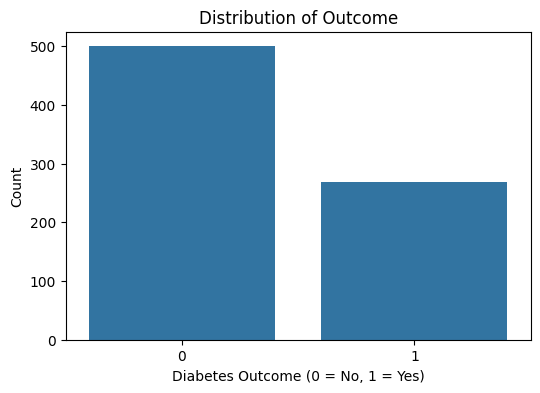

In [4]:
# Plot the distribution of the target variable (Outcome)
plt.figure(figsize=(6, 4))
sns.countplot(x='Outcome', data=pandas_df)
plt.title('Distribution of Outcome')
plt.xlabel('Diabetes Outcome (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

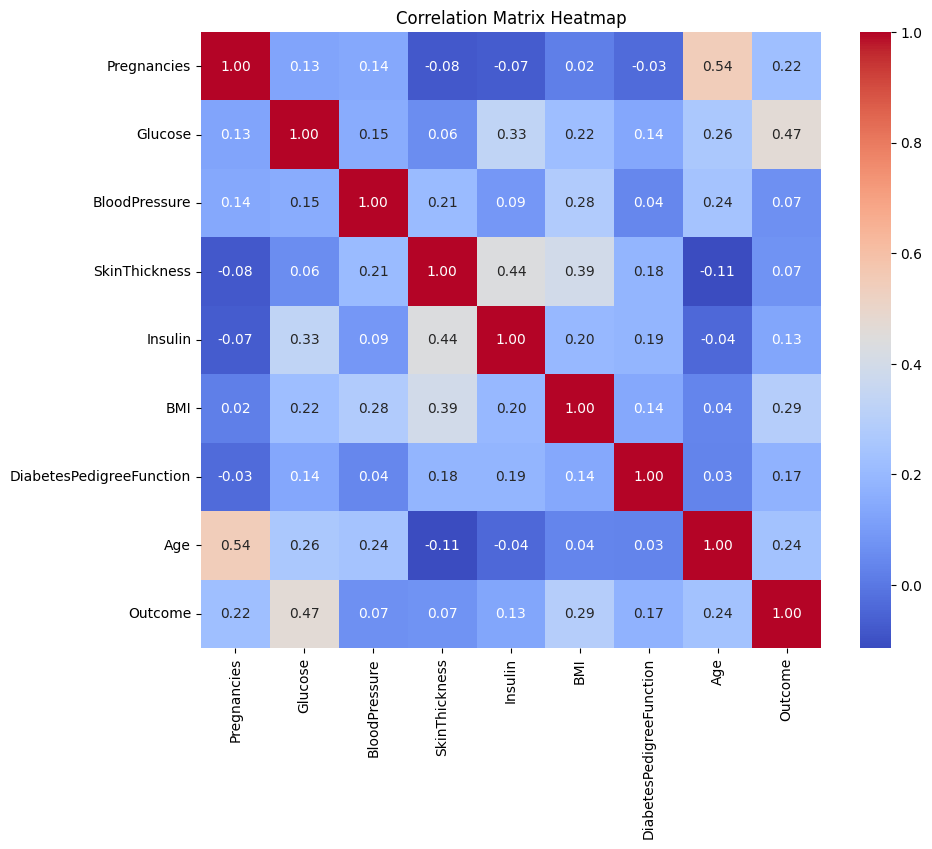

In [5]:
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = pandas_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

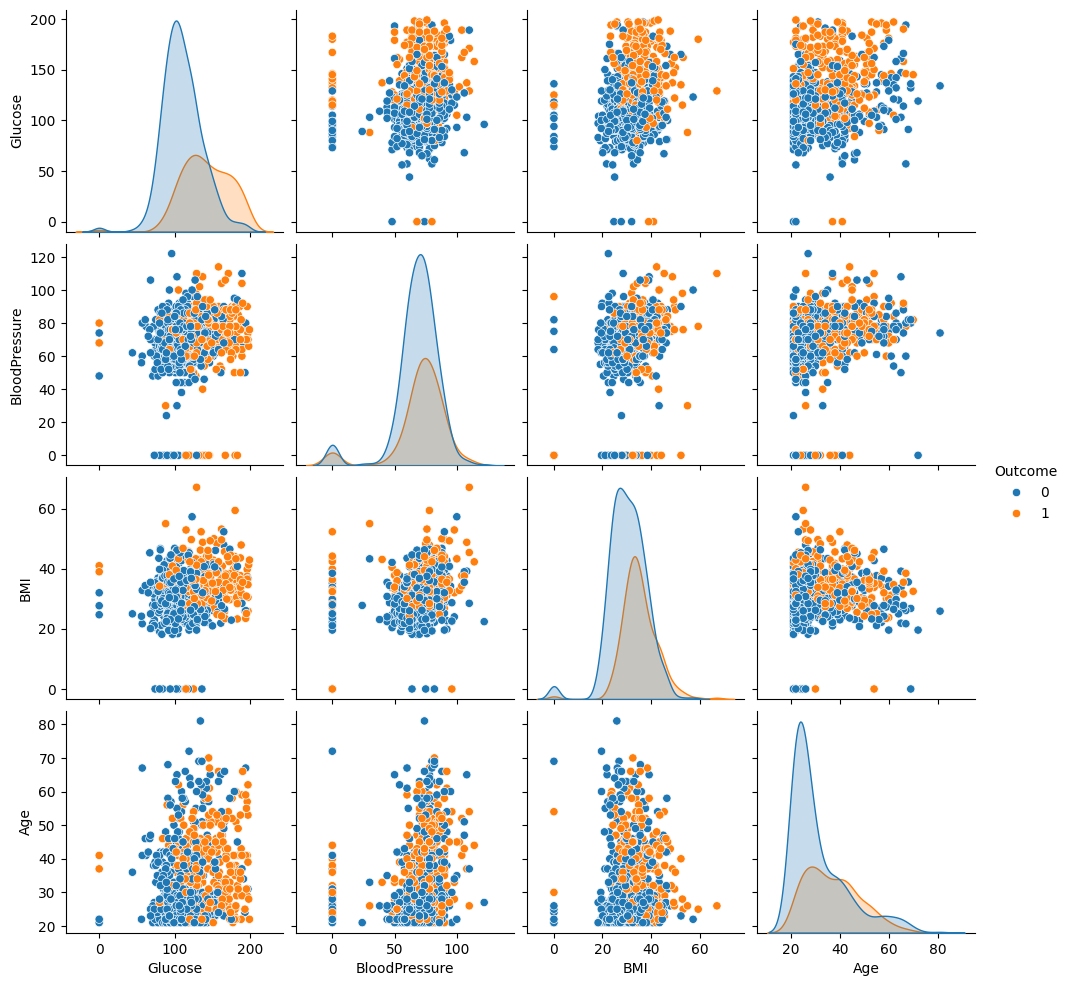

In [6]:
# Pairplot for selected features to visualize relationships
selected_features = ['Glucose', 'BloodPressure', 'BMI', 'Age', 'Outcome']
sns.pairplot(pandas_df[selected_features], hue='Outcome')
plt.show()

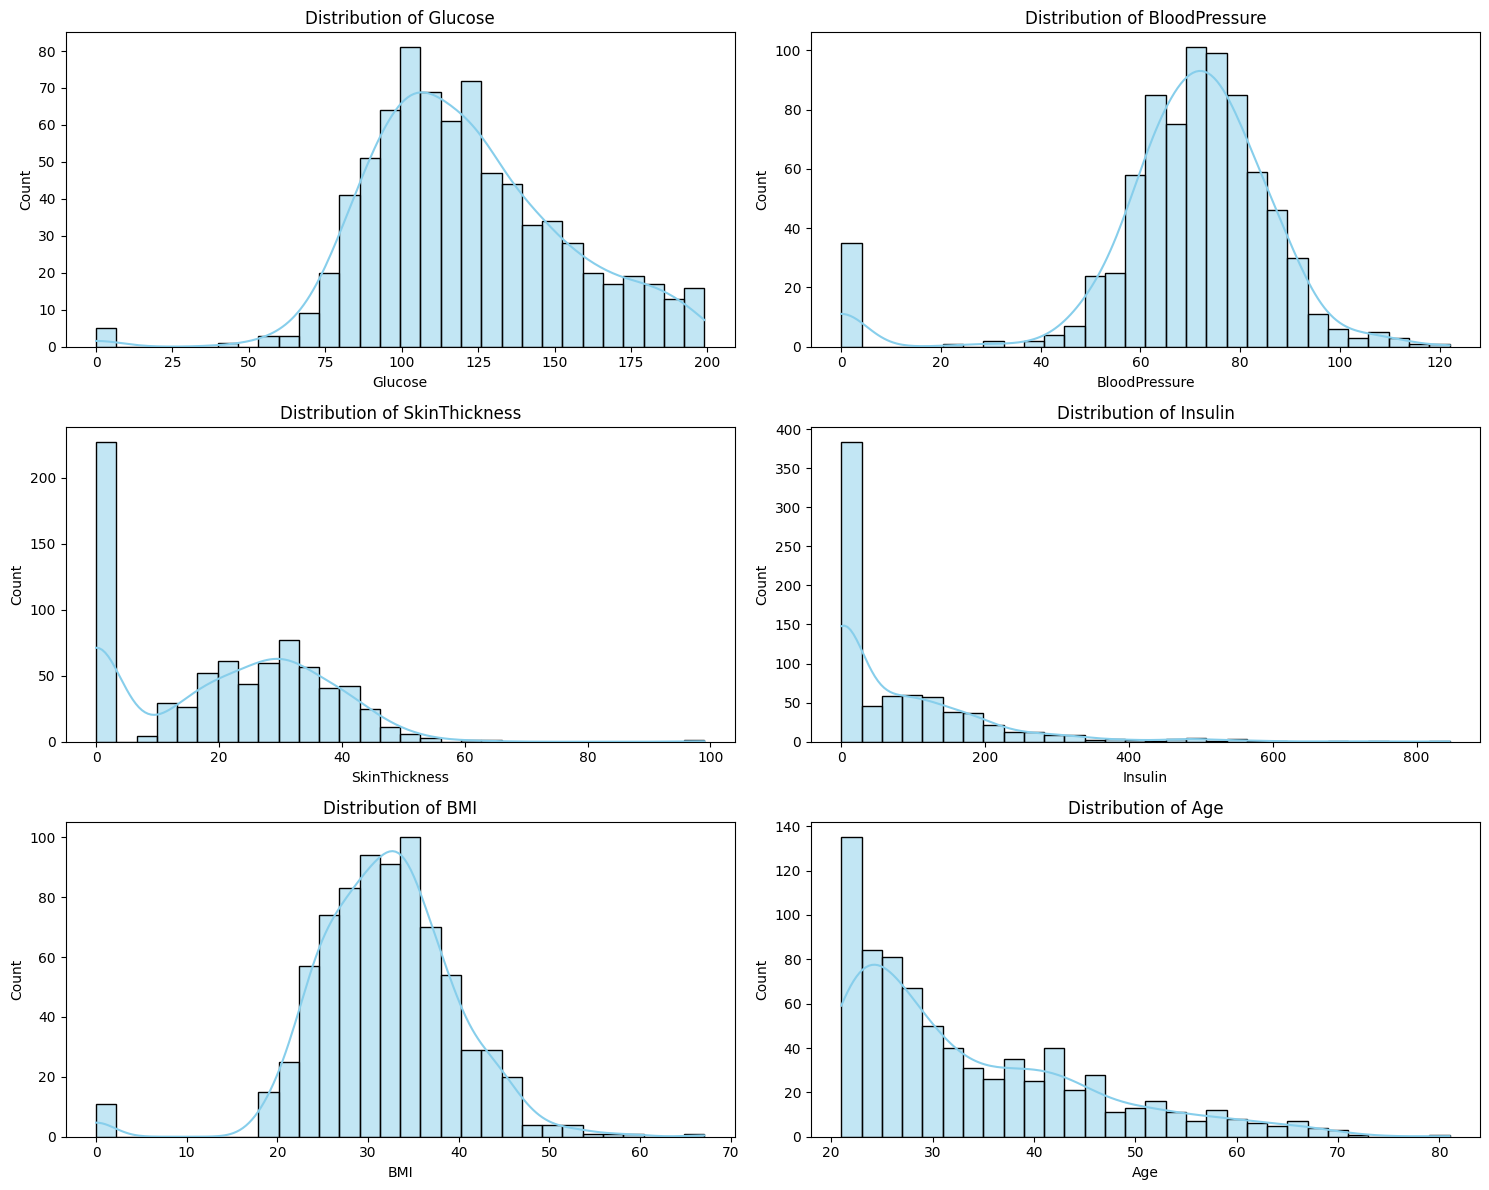

In [8]:
# Selected numeric features for distribution plots
selected_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age']

plt.figure(figsize=(15, 12))
for i, feature in enumerate(selected_features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(pandas_df[feature], kde=True, color='skyblue', bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)

plt.tight_layout()
plt.show()

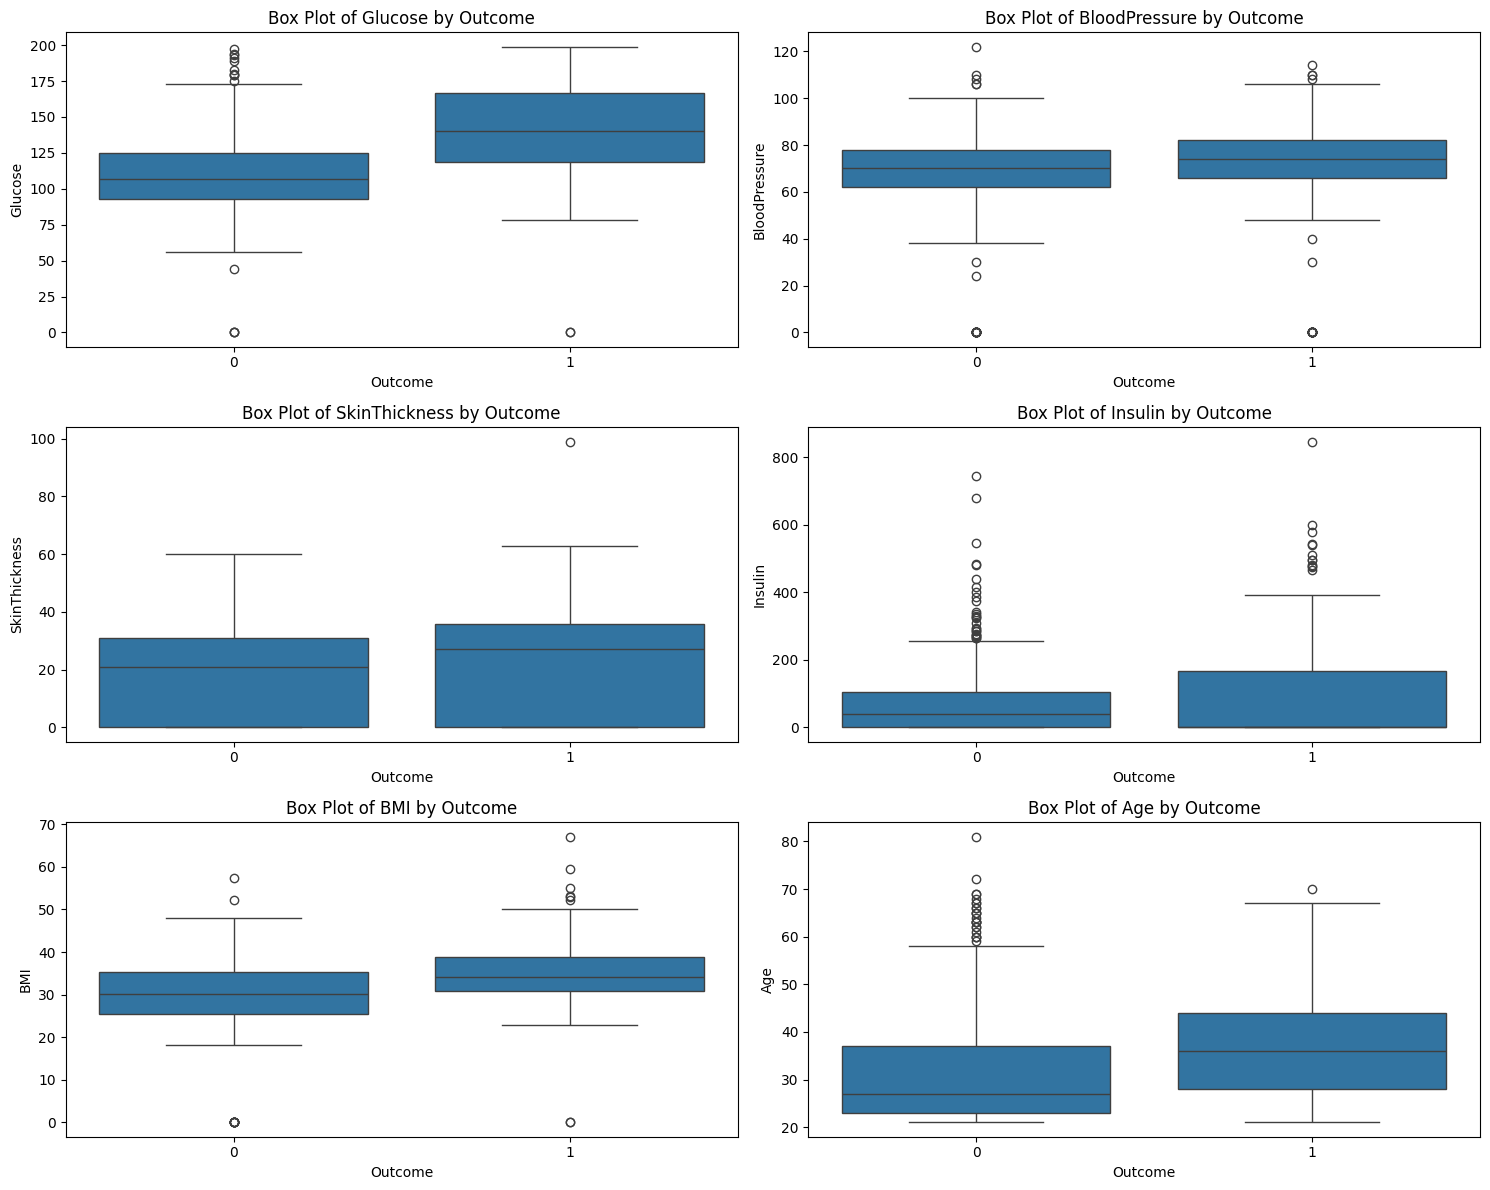

In [9]:
plt.figure(figsize=(15, 12))
for i, feature in enumerate(selected_features, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x='Outcome', y=feature, data=pandas_df)
    plt.title(f'Box Plot of {feature} by Outcome')
    plt.xlabel('Outcome')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

C:\Users\ahmad\AppData\Local\Temp\ipykernel_30308\109881580.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Outcome', y=feature, data=pandas_df, palette='muted')
C:\Users\ahmad\AppData\Local\Temp\ipykernel_30308\109881580.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Outcome', y=feature, data=pandas_df, palette='muted')
C:\Users\ahmad\AppData\Local\Temp\ipykernel_30308\109881580.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Outcome', y=feature, data=pandas_df, palette='muted')
C:\Users\ahmad\AppData\Local\Te

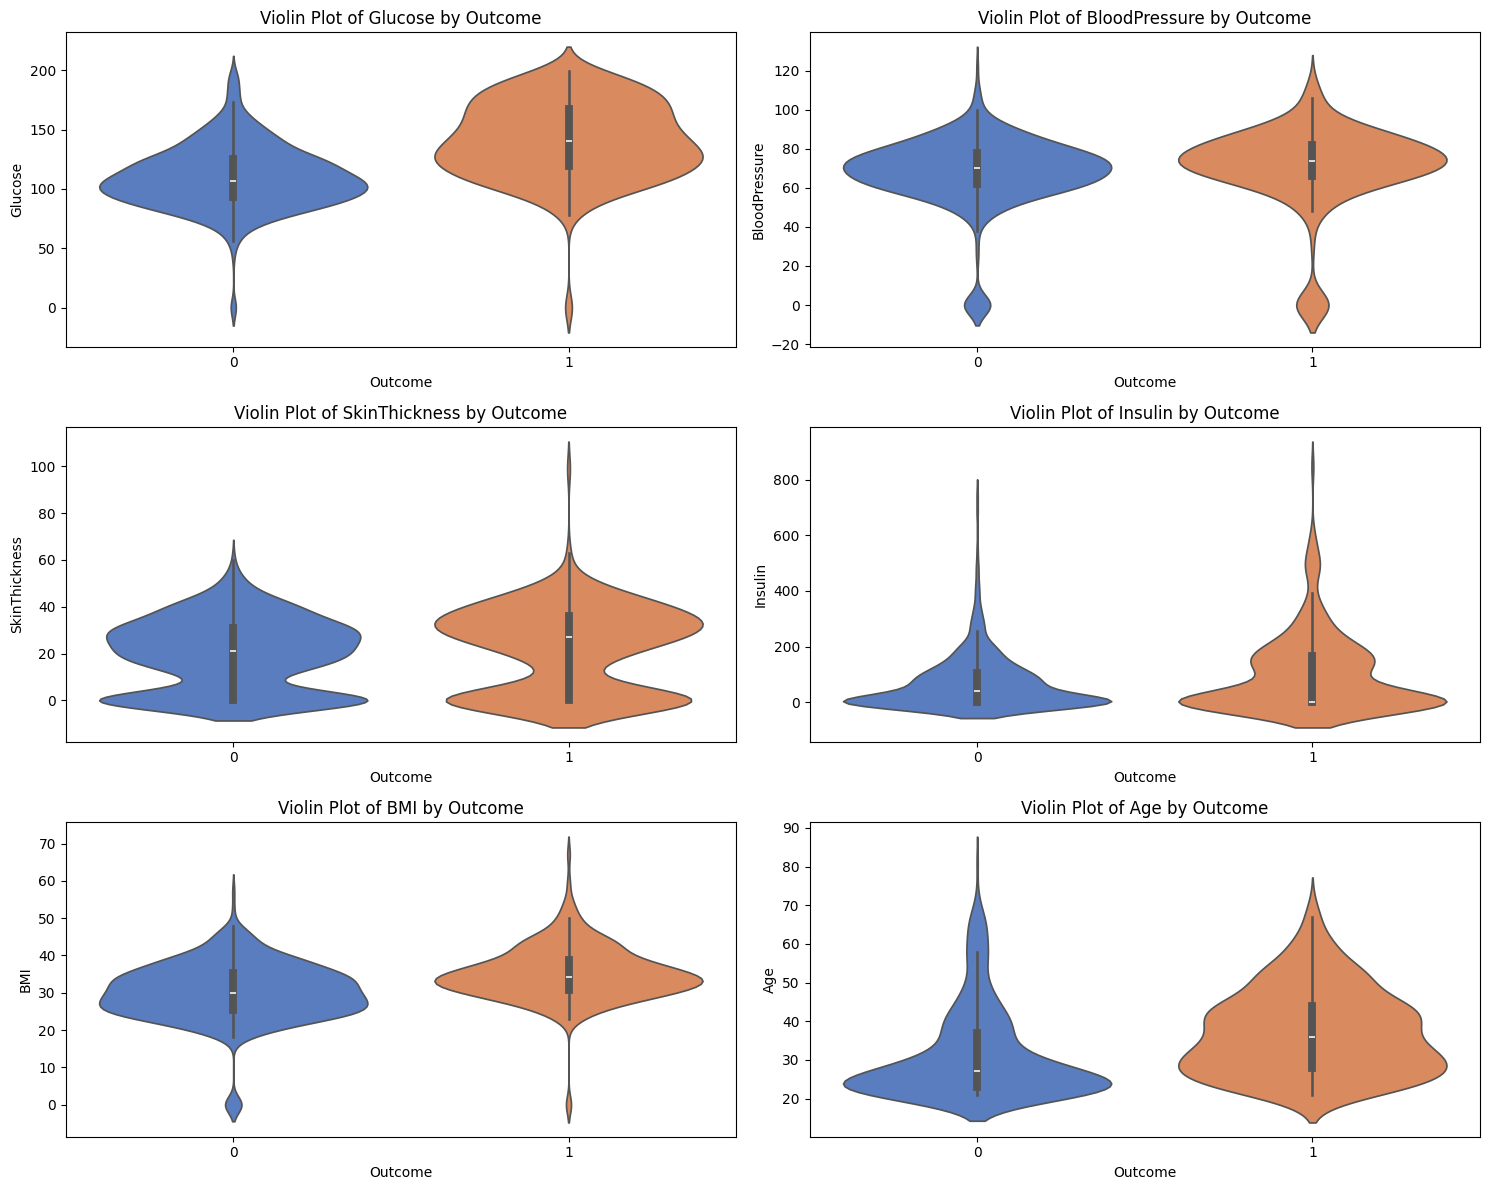

In [10]:
plt.figure(figsize=(15, 12))
for i, feature in enumerate(selected_features, 1):
    plt.subplot(3, 2, i)
    sns.violinplot(x='Outcome', y=feature, data=pandas_df, palette='muted')
    plt.title(f'Violin Plot of {feature} by Outcome')
    plt.xlabel('Outcome')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

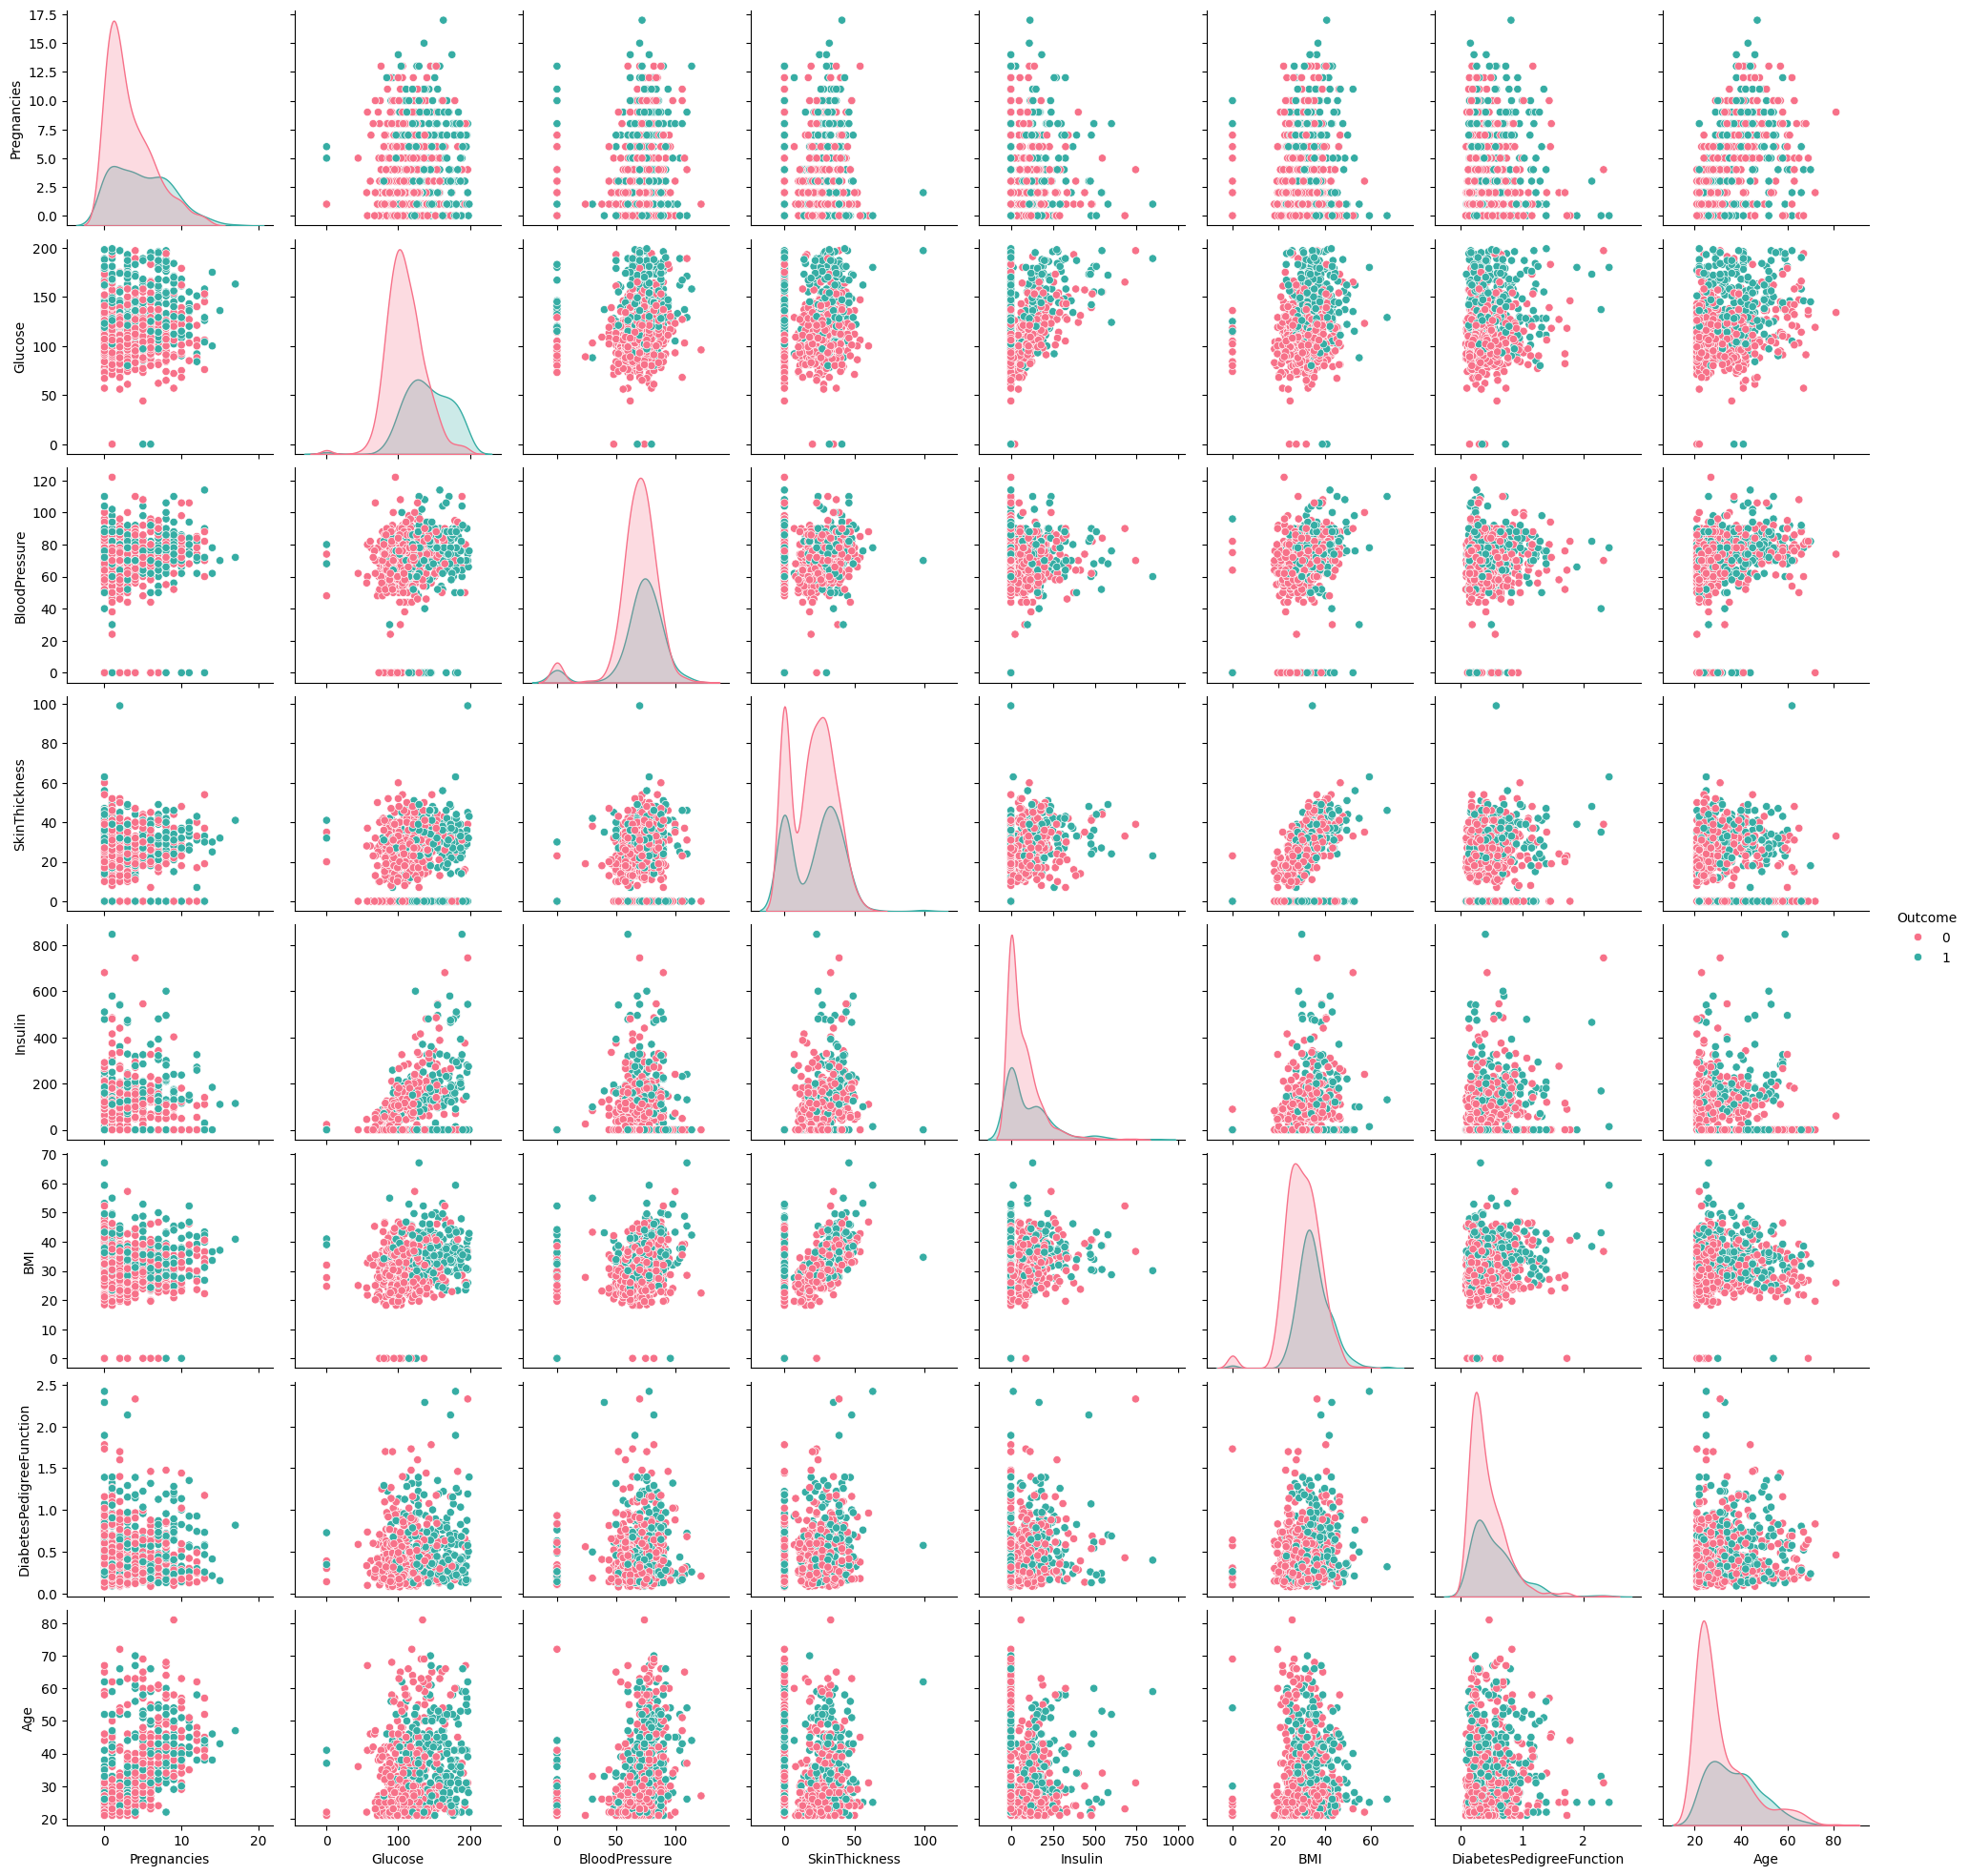

In [11]:
sns.pairplot(pandas_df, hue='Outcome', diag_kind='kde', palette='husl')
plt.show()

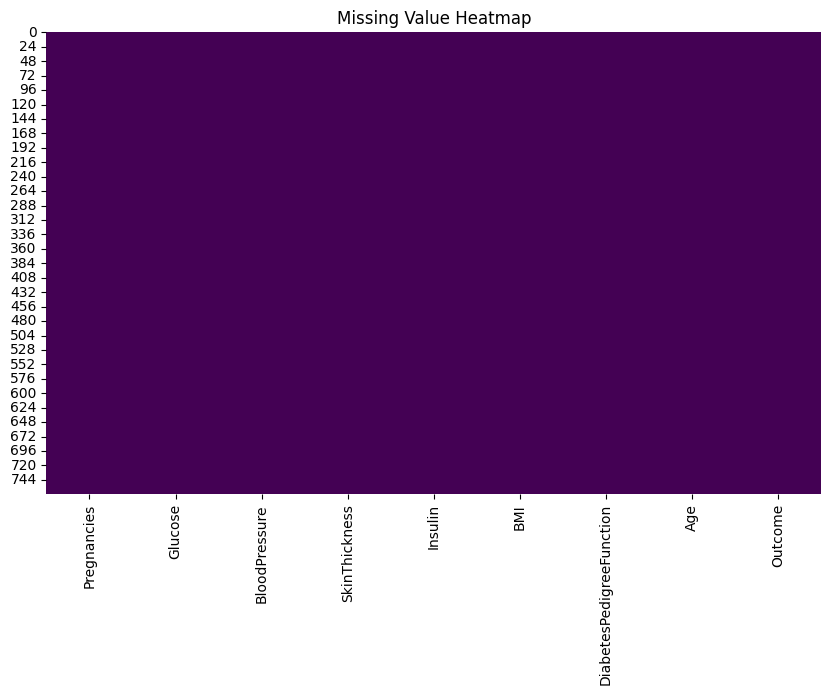

In [12]:
plt.figure(figsize=(10, 6))
sns.heatmap(pandas_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Value Heatmap')
plt.show()

Step 4: Data Exploration and Preprocessing

In [14]:
# Check for missing values by counting nulls in each column
from pyspark.sql.functions import col, sum

print("Missing Values:")
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

# Display summary statistics for numeric columns
print("\nDataset Description:")
df.describe().show()

# Display the schema and data types of the dataset
print("\nDataset Info:")
df.printSchema()

# Check for class imbalance in the Outcome column
print("\nOutcome Value Counts:")
df.groupBy('Outcome').count().show()

Missing Values:
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin|BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|          0|      0|            0|            0|      0|  0|                       0|  0|      0|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+


Dataset Description:
+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+
|summary|       Pregnancies|          Glucose|     BloodPressure|     SkinThickness|           Insulin|               BMI|DiabetesPedigreeFunction|               Age|           Outcome|
+-------+------------------+-----------------+------------------+------------------+----------

Step 5: Splitting the Dataset

In [15]:
# Assemble all feature columns into a single vector column
feature_cols = df.columns[:-1]  # All columns except 'Outcome'
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Transform the dataset to include the 'features' vector
df = assembler.transform(df)

# Select the 'features' and 'Outcome' columns, and rename 'Outcome' to 'label' for MLlib compatibility
data = df.select("features", col("Outcome").alias("label"))

# Split the dataset into 80% training and 20% testing
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Display the count of records in each split
print(f"Training Data Count: {train_data.count()}")
print(f"Testing Data Count: {test_data.count()}")

Training Data Count: 645
Testing Data Count: 123


Step 6: Training the Random Forest Model

In [18]:
# Initialize the Random Forest model with default parameters
rf_model = RandomForestClassifier(featuresCol="features", labelCol="label", seed=42)

# Train the model using the training data
rf_model = rf_model.fit(train_data)

Step 7: Evaluating the Random Forest Model

In [20]:
# Make predictions on the test data
rf_predictions = rf_model.transform(test_data)

# Initialize the evaluator for accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Calculate and print the accuracy score
accuracy_rf = evaluator.evaluate(rf_predictions)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")

Random Forest Accuracy: 0.78


Model Performance Visualizations

In [25]:
# Make predictions using the trained Random Forest model
rf_predictions = rf_model.transform(test_data)

# Convert predictions to Pandas DataFrame
rf_predictions_pd = rf_predictions.select("label", "prediction").toPandas()


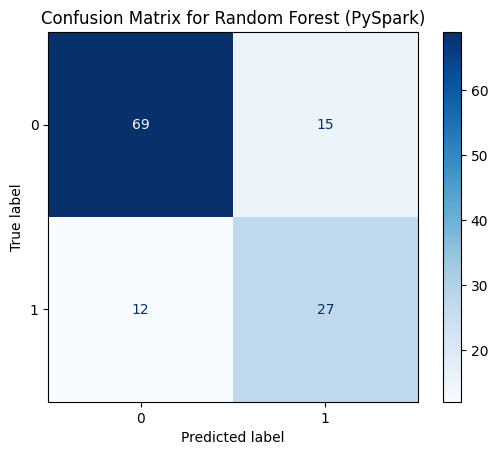

In [27]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(rf_predictions_pd['label'], rf_predictions_pd['prediction'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Random Forest (PySpark)')
plt.show()
